In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, SLSQP, ADAM, GradientDescent
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.connectors import TorchConnector
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

In [2]:
import tensorflow as tf
import collections
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [3]:
def filter_3649(x, y):
    keep = (y == 2) | (y == 4) | (y == 9)
    x, y = x[keep], y[keep]
    # y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_3649(x_train, y_train)
x_test, y_test = filter_3649(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 17749
Number of filtered test examples: 3023


4


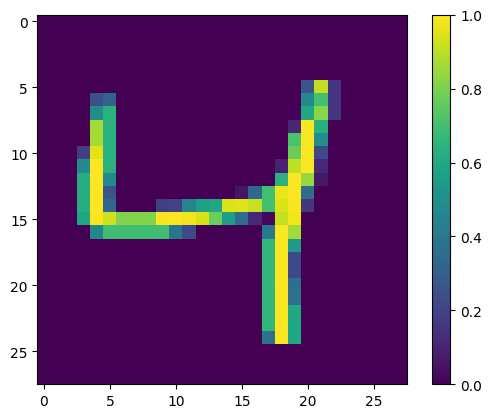

In [5]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [6]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

4


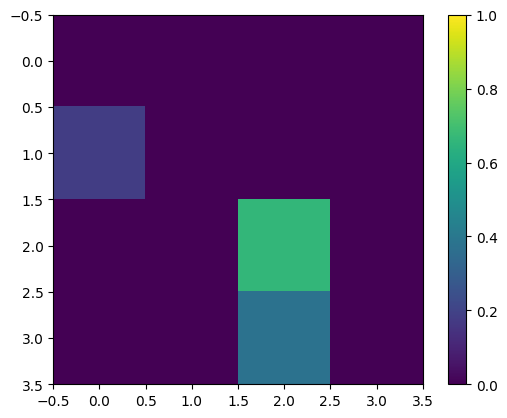

In [7]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [8]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and 1 in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and 2 in value)
    num_uniq_4 = sum(1 for value in mapping.values() if len(value) == 1 and 4 in value)
    num_uniq_9 = sum(1 for value in mapping.values() if len(value) == 1 and 9 in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) >= 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique 4s: ", num_uniq_4)
    print("Number of unique 9s: ", num_uniq_9)
    print("Number of unique contradicting labels: ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.asarray(new_x), np.asarray(new_y)

In [9]:
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 16016
Number of unique 3s:  0
Number of unique 6s:  5055
Number of unique 4s:  5215
Number of unique 9s:  5474
Number of unique contradicting labels:  272

Initial number of images:  17749
Remaining non-contradicting unique images:  15744
Number of unique images: 2866
Number of unique 3s:  0
Number of unique 6s:  937
Number of unique 4s:  934
Number of unique 9s:  964
Number of unique contradicting labels:  31

Initial number of images:  3023
Remaining non-contradicting unique images:  2835


In [10]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    
  
    print("weights", weights)
    print("objective function value", objective_func_vals)
    
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [11]:
num_inputs = 16
feature_map = ZZFeatureMap(num_inputs, reps = 2)
ansatz = RealAmplitudes(num_inputs, reps=10, entanglement = 'pairwise')
weights = [1.04381489e+00,2.56445119e-01,4.75863896e-01,1.79697998e+00
,1.04319866e+00,1.90595848e+00,9.76042547e-01,1.94419766e+00
,4.46928434e-02,9.33787565e-01,1.84951278e+00,7.90443662e-02
,1.36373777e-01,9.48211612e-01,6.74580123e-01,3.30497103e-01
,1.69980506e+00,1.59008947e+00,1.35973266e+00,8.77885861e-01
,8.12160115e-01,9.73735060e-01,8.49664701e-01,5.45921526e-01
,6.25468236e-01,1.13481798e-01,4.07679294e-01,1.60033804e-01
,1.21611132e+00,5.74108657e-01,5.81311272e-01,9.22507181e-01
,3.64464788e-01,7.96490747e-01,8.27495209e-01,1.16684015e-01
,5.04817731e-01,2.41778399e-01,7.86607855e-01,5.43667542e-01
,8.44044831e-01,9.05138628e-01,7.41847189e-01,6.04923537e-01
,9.37590543e-02,5.17390495e-01,2.19731759e-01,4.18516922e-01
,3.65254305e-01,5.25626107e-01,4.62018400e-01,9.30902892e-01
,5.12162073e-01,4.71171727e-01,9.24679637e-01,1.99878373e-01
,2.70560885e-01,1.95833873e-01,9.65712187e-01,2.19396367e-01
,2.77692556e-01,7.89521972e-01,3.46442495e-01,9.88212123e-01
,9.24325229e-01,7.35867001e-01,2.24663029e-01,7.15425365e-01
,7.59365703e-01,6.26600425e-01,8.24088368e-01,9.81536318e-02
,5.00558748e-02,7.30789086e-01,7.87650394e-01,4.13989517e-01
,7.87661434e-01,9.26172045e-02,2.24489312e-01,2.68006180e-02
,2.78577616e-01,2.50683852e-01,6.96179594e-01,2.87662017e-01
,7.21760369e-01,8.05089812e-01,8.92651523e-02,9.41327958e-01
,9.32996689e-01,1.00459878e-01,2.74863350e-01,7.03657415e-01
,4.02377972e-01,1.33163809e-01,3.25972443e-01,5.30548474e-01
,6.89484805e-01,6.43456597e-01,9.11330284e-01,9.57563987e-01
,2.41537809e-01,4.90146726e-01,1.33267877e-01,3.73725362e-01
,7.76952854e-01,8.08161203e-01,5.26909780e-01,1.77024984e-03
,8.80369913e-02,9.51060074e-01,1.05152651e-02,1.27238326e-03
,6.97007582e-01,5.64364889e-01,3.36916619e-01,7.24180774e-01
,2.76397214e-01,9.32245348e-01,3.83853081e-01,5.18243215e-02
,6.20984537e-01,8.69293148e-01,4.76968264e-01,4.14403954e-01
,1.22678222e-01,4.51357543e-01,6.95313650e-01,6.98426544e-01
,8.36293561e-01,2.75993360e-01,2.98747768e-01,8.81500087e-01
,7.04825084e-01,8.90673064e-01,8.92012103e-01,1.79968926e-01
,2.61664504e-01,4.75165527e-01,2.64951678e-01,4.83790432e-01
,8.85477600e-01,4.43750710e-01,5.72395151e-01,1.80666271e-01
,4.23631867e-01,5.90291920e-01,3.84616702e-01,6.47636764e-01
,1.49829720e-01,7.76364274e-01,9.95455634e-01,6.25401113e-01
,3.95909315e-01,6.36298267e-02,8.86471724e-01,1.35823875e-01
,3.68473326e-01,8.73670215e-01,2.40397937e-01,9.83492786e-01
,3.94434904e-01,1.63291493e-01,8.21390767e-01,2.72766905e-01
,8.67587651e-01,6.52176537e-01,3.13328928e-01,4.54670111e-01
,4.20662695e-01,9.61406395e-01,1.52858479e-01,1.20563617e-01
,6.01923090e-01,5.86985189e-01,6.30973528e-01,8.11048369e-01]

#  weights = [0.13481915 1.50611058 1.56262014 1.50015389 1.39160934 1.56193262
#  0.27765409 1.70032275 0.86051733 0.0735327  0.95293547 1.76873394
#  0.64998344 0.48614747 0.12926366 0.43096128 0.30018989 0.9702364
#  0.15785657 1.13390664 0.84934733 0.42154056 0.93716932 0.54311644
#  0.50682508 0.48317288 1.15416104 1.99061476 1.29438285 0.36334624
#  0.8985001  0.4471158  0.37840816 0.15256982 0.52144478 0.3700083
#  0.26239546 0.84922159 0.9577151  0.26674097 0.64495168 0.33047589
#  0.67377122 0.90953842 0.71423471 0.42334928 0.0032611  0.83543539
#  0.88669264 0.99043674 0.71631231 0.71228866 0.80742238 0.90781306
#  0.25298772 0.58101076 0.86419399 0.19983204 0.03470823 0.84468234
#  0.73740292 0.7817162  0.14366909 0.62608322 0.0294518  0.1971866
#  0.55829743 0.44526973 0.39530846 0.03208847 0.52542653 0.5802067
#  0.85654836 0.69236882 0.38482838 0.83799974 0.7133025  0.39118172
#  0.22208527 0.4523234  0.97617413 0.74778346 0.47345196 0.24303363
#  0.19660515 0.94323655 0.12908269 0.78383233 0.32893903 0.08092164
#  0.81014285 0.87712201 0.53227796 0.97319222 0.70351817 0.29307241
#  0.41368903 0.9861649  0.45515514 0.13766437 0.29211231 0.4212242
#  0.80968633 0.66645838 0.84523229 0.43465311 0.28111861 0.20883336
#  0.99299555 0.20821255 0.29457338 0.97058611 0.92502003 0.20987457
#  0.36271945 0.6867945  0.14706893 0.02916717 0.70887333 0.36806808
#  0.88513181 0.92472992 0.97341428 0.86597279 0.35367663 0.66968212
#  0.76712941 0.46463591 0.17235383 0.77127967 0.65533756 0.17022252
#  0.09485729 0.14200325 0.40418287 0.90697016 0.37806695 0.55242659
#  0.60100574 0.3783111  0.63823206 0.11417934 0.8180545  0.7873124
#  0.64246266 0.03388347 0.67464173 0.23189445 0.34731615 0.89601624
#  0.48750248 0.97197522 0.56959339 0.17044498 0.10933407 0.45782791
#  0.09641331 0.57788015 0.32315581 0.70421846 0.3263225  0.51587299
#  0.43057217 0.06408476 0.04810956 0.83139252 0.81999029 0.43340617
#  0.33933778 0.67919046 0.24002798 0.11951999 0.73739118 0.47948978
#  0.95991374 0.88294117]

In [12]:
classifier = VQC(
    feature_map = feature_map,
    ansatz = ansatz,
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
    warm_start = True
    )

In [13]:
x_reshaped = []
x1_reshaped = []

for b in resized_train_images:
    x_reshaped.append(b.reshape(1,16))

for b in resized_test_images:
    x1_reshaped.append(b.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    #print("entry \n" , entry[0])
    final_x.append(entry[0])

for entry in x1_reshaped:
    #print("entry \n" , entry[0])
    final_x1.append(entry[0])

objective_func_vals = []

x = np.asarray(final_x)
y = np.asarray(train_labels)

x = x[2000:2050]
y = y[2000:2050]

print(x)
print(y)

[[0.         0.         0.         0.         0.         0.09411765
  0.99607843 0.         0.         0.7411765  0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.8745098
  0.7764706  0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.99607843
  0.7058824  0.         0.         0.         0.23529412 0.
  0.         0.         0.15294118 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.99607843 0.         0.         0.49019608 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.91764706
  0.07058824 0.         0.         0.99215686 0.99215686 0.
  0.         0.         0.         0.        ]
 [0.         0.98039216 0.         0.         0.         0.
  0.9764706  0.         0.         0.10980392 0.         0.
  0.         0

weights [0.13481915 1.50611058 1.56262014 1.50015389 1.39160934 1.56193262
 0.27765409 1.70032275 0.86051733 0.0735327  0.95293547 1.76873394
 0.64998344 0.48614747 0.12926366 0.43096128 0.30018989 0.9702364
 0.15785657 1.13390664 0.84934733 0.42154056 0.93716932 0.54311644
 0.50682508 0.48317288 1.15416104 1.99061476 1.29438285 0.36334624
 0.8985001  0.4471158  0.37840816 0.15256982 0.52144478 0.3700083
 0.26239546 0.84922159 0.9577151  0.26674097 0.64495168 0.33047589
 0.67377122 0.90953842 0.71423471 0.42334928 0.0032611  0.83543539
 0.88669264 0.99043674 0.71631231 0.71228866 0.80742238 0.90781306
 0.25298772 0.58101076 0.86419399 0.19983204 0.03470823 0.84468234
 0.73740292 0.7817162  0.14366909 0.62608322 0.0294518  0.1971866
 0.55829743 0.44526973 0.39530846 0.03208847 0.52542653 0.5802067
 0.85654836 0.69236882 0.38482838 0.83799974 0.7133025  0.39118172
 0.22208527 0.4523234  0.97617413 0.74778346 0.47345196 0.24303363
 0.19660515 0.94323655 0.12908269 0.78383233 0.32893903 0.

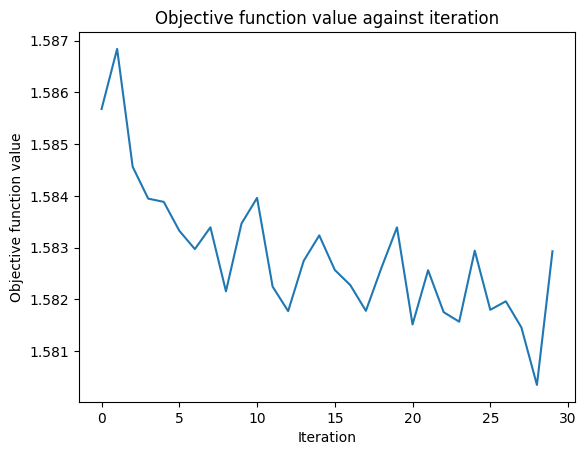

In [14]:
classifier.fit(x,y)

In [15]:
print(f"Accuracy from the train data: {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the train data: 52.0%


In [20]:
x1 = np.asarray(final_x1)
y1 = np.asarray(test_labels)
        
x1 = x1[:50]
y1 = y1[:50]
y_predict = classifier.predict(x1)

print(f"Accuracy from the test data: {np.round(100 * classifier.score(x1, y1), 2)}%")

Accuracy from the test data: 42.0%


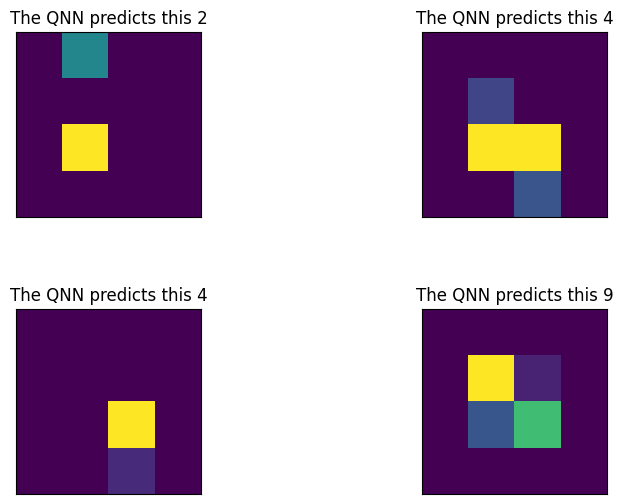

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QNN predicts this is 1")
    if y_predict[i] == 2:
        ax[i // 2, i % 2].set_title("The QNN predicts this 2")
    if y_predict[i] == 4:
        ax[i // 2, i % 2].set_title("The QNN predicts this 4")   
    if y_predict[i] == 9:
        ax[i // 2, i % 2].set_title("The QNN predicts this 9") 
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [22]:
y_predict

array([2, 4, 4, 9, 4, 4, 9, 4, 4, 2, 2, 4, 2, 2, 9, 2, 9, 9, 9, 2, 4, 9,
       4, 2, 4, 2, 4, 2, 2, 9, 9, 2, 9, 9, 2, 2, 4, 4, 2, 2, 9, 2, 2, 2,
       9, 4, 4, 9, 9, 4], dtype=uint8)

In [23]:
y1

array([2, 4, 4, 9, 9, 9, 9, 4, 9, 4, 4, 4, 2, 2, 4, 2, 2, 4, 4, 9, 9, 4,
       4, 2, 9, 2, 9, 2, 4, 9, 4, 9, 4, 9, 9, 2, 9, 4, 9, 4, 4, 4, 9, 4,
       9, 4, 2, 2, 9, 9], dtype=uint8)